Important: our tensors are left-padded. For SASRec we’ll convert to right-padded for clean causal masking.

In [1]:
# Quick (unsafe) workaround to avoid the libiomp5md.dll crash.
# Use this only to continue working in the notebook quickly.
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print("Set KMP_DUPLICATE_LIB_OK=TRUE — restart kernel and re-run cells now.")

Set KMP_DUPLICATE_LIB_OK=TRUE — restart kernel and re-run cells now.


Imports & start

In [2]:
# CELL [10-01] — Imports & start

import json
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader

print("[10-01] Starting 10_sasrec_small_baseline.ipynb")
print("[10-01] torch:", torch.__version__)


[10-01] Starting 10_sasrec_small_baseline.ipynb
[10-01] torch: 2.5.1


Paths, device, metadata

In [3]:
# CELL [10-02] — Paths, device, metadata

DATA_DIR = Path("../data/processed")
SHARDS_DIR = DATA_DIR / "tensor_shards_v2"
META_PATH = SHARDS_DIR / "metadata.json"
RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(exist_ok=True)

assert META_PATH.exists(), f"[10-02] Missing: {META_PATH}"

with open(META_PATH, "r") as f:
    meta = json.load(f)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_PREFIX_LEN = meta["max_prefix_len"]
PAD_ID = meta["pad_id"]
UNK_ID = meta["unk_id"]
TARGET_VOCAB_SIZE = meta["vocab"]["target"]["size"]

print("[10-02] SHARDS_DIR:", SHARDS_DIR.resolve())
print("[10-02] DEVICE:", DEVICE)
print("[10-02] MAX_PREFIX_LEN:", MAX_PREFIX_LEN)
print("[10-02] TARGET_VOCAB_SIZE:", TARGET_VOCAB_SIZE)


[10-02] SHARDS_DIR: D:\00_DS-ML-Workspace\session-transfer-mooc\data\processed\tensor_shards_v2
[10-02] DEVICE: cuda
[10-02] MAX_PREFIX_LEN: 20
[10-02] TARGET_VOCAB_SIZE: 702


Loader utilities (self-contained)

In [5]:
# CELL [10-03] — Loader utilities (same style as 08/09)

def list_shards(domain: str, split: str) -> List[Path]:
    files = sorted(SHARDS_DIR.glob(f"{domain}_{split}_shard_*.pt"))
    return files

class ShardExamplesDataset(IterableDataset):
    def __init__(self, shard_paths: List[Path]):
        super().__init__()
        self.shard_paths = list(shard_paths)

    def __iter__(self):
        for sp in self.shard_paths:
            shard = torch.load(sp, map_location="cpu", weights_only=True)
            n = shard["input_ids"].shape[0]
            for i in range(n):
                yield {
                    "input_ids": shard["input_ids"][i],
                    "attention_mask": shard["attention_mask"][i],
                    "pos_ids": shard["pos_ids"][i],
                    "labels": shard["labels"][i],
                    "lengths": shard["lengths"][i],
                }

def collate_batch(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch], dim=0),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch], dim=0),
        "pos_ids": torch.stack([x["pos_ids"] for x in batch], dim=0),
        "labels": torch.stack([x["labels"] for x in batch], dim=0),
        "lengths": torch.stack([x["lengths"] for x in batch], dim=0),
    }

def make_loader(domain: str, split: str, batch_size: int) -> DataLoader:
    shard_paths = list_shards(domain, split)
    assert len(shard_paths) > 0, f"[10-03] No shards found for {domain}/{split}"
    ds = ShardExamplesDataset(shard_paths)
    dl = DataLoader(ds, batch_size=batch_size, num_workers=0, collate_fn=collate_batch, drop_last=False)
    print(f"[10-03] Loader ready: {domain}/{split}, shards={len(shard_paths)}, batch_size={batch_size}")
    return dl


Metrics (Recall@20, MRR@20)

In [6]:
# CELL [10-04] — Metrics

@torch.no_grad()
def recall_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> float:
    topk = torch.topk(scores, k=k, dim=1).indices
    hit = (topk == labels.unsqueeze(1)).any(dim=1).float()
    return float(hit.mean().item())

@torch.no_grad()
def mrr_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> float:
    topk = torch.topk(scores, k=k, dim=1).indices
    match = (topk == labels.unsqueeze(1))
    ranks = torch.arange(1, k + 1, device=scores.device).unsqueeze(0)
    rr = torch.where(match, 1.0 / ranks, torch.zeros_like(ranks, dtype=torch.float))
    return float(rr.max(dim=1).values.mean().item())


Left-pad → Right-pad conversion

In [7]:
# CELL [10-05] — Left-pad -> Right-pad conversion

def leftpad_to_rightpad(input_ids: torch.Tensor, lengths: torch.Tensor, pad_id: int) -> torch.Tensor:
    B, T = input_ids.shape
    out = torch.full_like(input_ids, fill_value=pad_id)
    for i in range(B):
        L = int(lengths[i].item())
        if L <= 0:
            continue
        seq = input_ids[i, T - L:T]
        out[i, 0:L] = seq
    return out


SASRecSmall model (Transformer encoder)

In [9]:
# CELL [10-06] — SASRecSmall (Transformer)

class SASRecSmall(nn.Module):
    """
    Minimal SASRec-like model:
    - token embedding + positional embedding
    - TransformerEncoder (causal mask)
    - use last valid position representation -> logits over items
    """
    def __init__(self, vocab_size: int, max_len: int, d_model: int = 64, n_heads: int = 2, n_layers: int = 2, dropout: float = 0.1, pad_id: int = 0):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.pad_id = pad_id

        self.item_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos_emb = nn.Embedding(max_len, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)

        self.out = nn.Linear(d_model, vocab_size)

    def causal_mask(self, T: int, device: torch.device):
        # True = masked (PyTorch expects bool mask with True meaning "don't attend")
        return torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)

    def forward(self, input_ids: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        """
        input_ids: [B,T] right-padded
        lengths: [B]
        """
        B, T = input_ids.shape
        device = input_ids.device

        pos = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        x = self.item_emb(input_ids) + self.pos_emb(pos)
        x = self.dropout(x)
        x = self.ln(x)

        attn_mask = self.causal_mask(T, device=device)  # [T,T]
        key_padding_mask = (input_ids == self.pad_id)   # [B,T], True where PAD

        h = self.encoder(x, mask=attn_mask, src_key_padding_mask=key_padding_mask)  # [B,T,D]

        # gather representation at last valid timestep (length-1)
        idx = (lengths - 1).clamp(min=0).unsqueeze(1).unsqueeze(2).expand(B, 1, h.size(-1))
        last_h = h.gather(dim=1, index=idx).squeeze(1)  # [B,D]

        logits = self.out(last_h)  # [B,V]
        return logits


Training config (Small + regularized)

In [10]:
# CELL [10-07] — Config

CFG = {
    "d_model": 64,
    "n_heads": 2,
    "n_layers": 2,
    "dropout": 0.2,
    "lr": 5e-4,
    "weight_decay": 1e-4,
    "batch_size": 256,
    "epochs": 20,
    "eval_k": 20,
    "early_stop_patience": 4,
    "grad_clip": 1.0,
}

print("[10-07] CFG:", CFG)


[10-07] CFG: {'d_model': 64, 'n_heads': 2, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 0.0001, 'batch_size': 256, 'epochs': 20, 'eval_k': 20, 'early_stop_patience': 4, 'grad_clip': 1.0}


Loaders

In [11]:
# CELL [10-08] — Loaders

train_loader = make_loader("mars", "train", batch_size=CFG["batch_size"])
val_loader   = make_loader("mars", "val",   batch_size=CFG["batch_size"])
test_loader  = make_loader("mars", "test",  batch_size=CFG["batch_size"])


[10-03] Loader ready: mars/train, shards=1, batch_size=256
[10-03] Loader ready: mars/val, shards=1, batch_size=256
[10-03] Loader ready: mars/test, shards=1, batch_size=256


Train/eval functions (with grad clipping)

In [12]:
# CELL [10-09] — Train/Eval loops

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for bi, batch in enumerate(loader, 1):
        input_ids = batch["input_ids"].to(device)
        lengths   = batch["lengths"].to(device)
        labels    = batch["labels"].to(device)

        input_rp = leftpad_to_rightpad(input_ids, lengths, PAD_ID)

        logits = model(input_rp, lengths)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        if CFG.get("grad_clip") is not None:
            nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])

        optimizer.step()

        total_loss += float(loss.item())
        n_batches += 1

        if bi % 20 == 0:
            print(f"[10-09][TRAIN] batch={bi} loss={loss.item():.4f}")

    return total_loss / max(n_batches, 1)

@torch.no_grad()
def eval_model(model, loader, k: int, device):
    model.eval()
    recalls = []
    mrrs = []
    total = 0

    for bi, batch in enumerate(loader, 1):
        input_ids = batch["input_ids"].to(device)
        lengths   = batch["lengths"].to(device)
        labels    = batch["labels"].to(device)

        input_rp = leftpad_to_rightpad(input_ids, lengths, PAD_ID)
        logits = model(input_rp, lengths)

        recalls.append(recall_at_k(logits, labels, k))
        mrrs.append(mrr_at_k(logits, labels, k))
        total += labels.size(0)

        if bi % 20 == 0:
            print(f"[10-09][EVAL] batch={bi} running_total={total}")

    return {
        f"Recall@{k}": sum(recalls) / max(len(recalls), 1),
        f"MRR@{k}": sum(mrrs) / max(len(mrrs), 1),
        "num_examples": total
    }


Train with early stopping (Val MRR@20)

In [13]:
# CELL [10-10] — Train loop with early stopping

history = []
model = SASRecSmall(
    vocab_size=TARGET_VOCAB_SIZE,
    max_len=MAX_PREFIX_LEN,
    d_model=CFG["d_model"],
    n_heads=CFG["n_heads"],
    n_layers=CFG["n_layers"],
    dropout=CFG["dropout"],
    pad_id=PAD_ID
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

best_val_mrr = -1.0
best_state = None
patience = 0

for epoch in range(1, CFG["epochs"] + 1):
    print(f"\n[10-10] Epoch {epoch}/{CFG['epochs']}")

    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE)
    val_metrics = eval_model(model, val_loader, k=CFG["eval_k"], device=DEVICE)

    history.append({
        "epoch": epoch,
        "train_loss": float(train_loss),
        "val_recall": float(val_metrics[f"Recall@{CFG['eval_k']}"]),
        "val_mrr": float(val_metrics[f"MRR@{CFG['eval_k']}"]),
    })

    print(f"[10-10] train_loss={train_loss:.4f} | val={val_metrics}")

    val_mrr = val_metrics[f"MRR@{CFG['eval_k']}"]
    if val_mrr > best_val_mrr:
        best_val_mrr = val_mrr
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        patience = 0
        print(f"[10-10] New best val MRR@{CFG['eval_k']}: {best_val_mrr:.6f}")
    else:
        patience += 1
        print(f"[10-10] No improvement. patience={patience}/{CFG['early_stop_patience']}")
        if patience >= CFG["early_stop_patience"]:
            print("[10-10] Early stopping triggered.")
            break


c:\Users\User\miniconda3\envs\session-transfer-mooc\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



[10-10] Epoch 1/20
[10-10] train_loss=6.7926 | val={'Recall@20': 0.09089543670415878, 'MRR@20': 0.028002644889056683, 'num_examples': 282}
[10-10] New best val MRR@20: 0.028003

[10-10] Epoch 2/20
[10-10] train_loss=6.5921 | val={'Recall@20': 0.11989182978868484, 'MRR@20': 0.07196423597633839, 'num_examples': 282}
[10-10] New best val MRR@20: 0.071964

[10-10] Epoch 3/20
[10-10] train_loss=6.4622 | val={'Recall@20': 0.1625600978732109, 'MRR@20': 0.07985221780836582, 'num_examples': 282}
[10-10] New best val MRR@20: 0.079852

[10-10] Epoch 4/20
[10-10] train_loss=6.3379 | val={'Recall@20': 0.18960337340831757, 'MRR@20': 0.0853022038936615, 'num_examples': 282}
[10-10] New best val MRR@20: 0.085302

[10-10] Epoch 5/20
[10-10] train_loss=6.2158 | val={'Recall@20': 0.2456430345773697, 'MRR@20': 0.10102352499961853, 'num_examples': 282}
[10-10] New best val MRR@20: 0.101024

[10-10] Epoch 6/20
[10-10] train_loss=6.0918 | val={'Recall@20': 0.28245192766189575, 'MRR@20': 0.10913845524191856,

Best checkpoint eval (VAL + TEST)

In [14]:
# CELL [10-11] — Best checkpoint eval (VAL + TEST)

assert best_state is not None, "[10-11] best_state is None — training did not run properly"

model.load_state_dict(best_state)

best_val = eval_model(model, val_loader, k=CFG["eval_k"], device=DEVICE)
best_test = eval_model(model, test_loader, k=CFG["eval_k"], device=DEVICE)

print("[10-11] Best SASRecSmall VAL:", best_val)
print("[10-11] Best SASRecSmall TEST:", best_test)


[10-11] Best SASRecSmall VAL: {'Recall@20': 0.5166766941547394, 'MRR@20': 0.30823491513729095, 'num_examples': 282}
[10-11] Best SASRecSmall TEST: {'Recall@20': 0.41187959909439087, 'MRR@20': 0.221835158765316, 'num_examples': 358}


Save metrics + checkpoint

In [15]:
# CELL [10-12] — Save outputs

out = {
    "model": "SASRecSmall",
    "dataset": "mars",
    "config": CFG,
    "best_val": best_val,
    "best_test": best_test,
}

metrics_path = RESULTS_DIR / "sasrec_small_mars_baseline.json"
ckpt_path = RESULTS_DIR / "sasrec_small_mars_baseline.pt"

with open(metrics_path, "w") as f:
    json.dump(out, f, indent=2)

torch.save(best_state, ckpt_path)

print("[10-12] Saved metrics:", metrics_path.resolve())
print("[10-12] Saved checkpoint:", ckpt_path.resolve())


[10-12] Saved metrics: D:\00_DS-ML-Workspace\session-transfer-mooc\results\sasrec_small_mars_baseline.json
[10-12] Saved checkpoint: D:\00_DS-ML-Workspace\session-transfer-mooc\results\sasrec_small_mars_baseline.pt


Compare vs KNN + GRU4Rec + NARM + plots

[10-13] Comparison table:


Recall@20    MRR@20  num_examples
model       split                                   
Session-KNN val     0.631206  0.144551           282
            test    0.681564  0.141597           358
GRU4Rec     val     0.598708  0.362829           282
            test    0.625306  0.430546           358
NARM        val     0.623498  0.381832           282
            test    0.575406  0.377906           358
SASRecSmall val     0.516677  0.308235           282
            test    0.411880  0.221835           358

[10-13] Saved CSV: D:\00_DS-ML-Workspace\session-transfer-mooc\results\baseline_comparison_mars_all4.csv


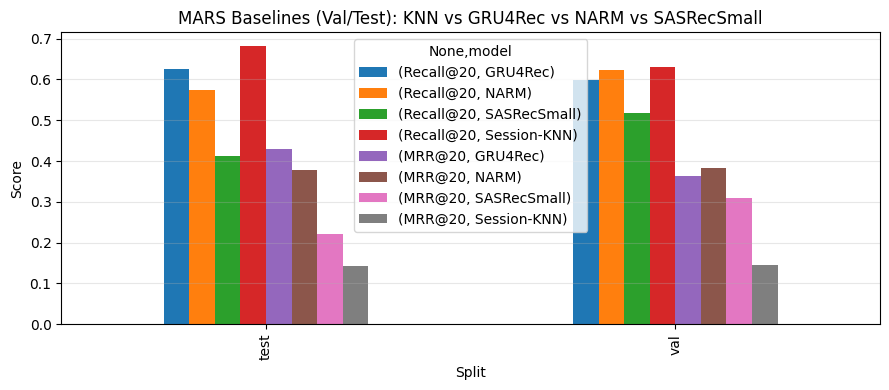

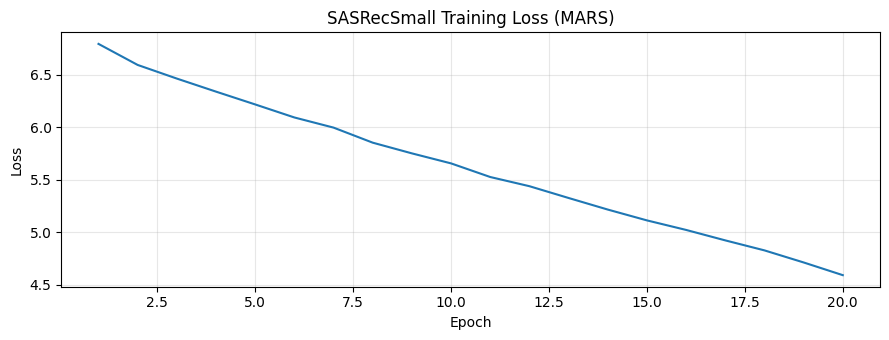

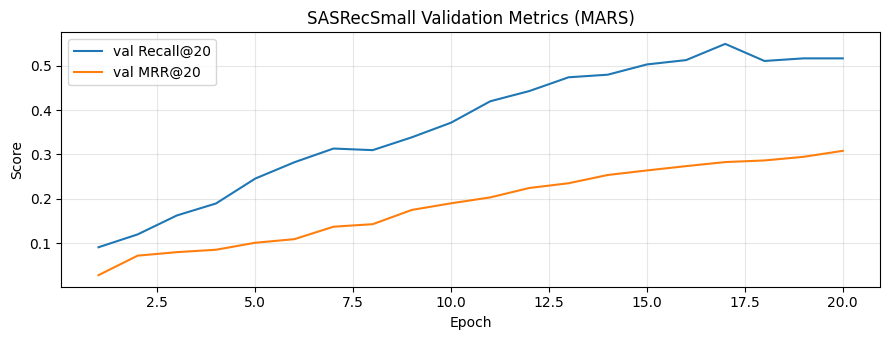

In [16]:
# CELL [10-13] — Compare baselines + plots

import pandas as pd
import matplotlib.pyplot as plt

sk_val = json.load(open(RESULTS_DIR / "session_knn_mars_val.json"))
sk_test = json.load(open(RESULTS_DIR / "session_knn_mars_test.json"))
gru = json.load(open(RESULTS_DIR / "gru4rec_mars_baseline.json"))
narm = json.load(open(RESULTS_DIR / "narm_mars_baseline.json"))

rows = [
    {"model":"Session-KNN",  "split":"val",  **sk_val},
    {"model":"Session-KNN",  "split":"test", **sk_test},
    {"model":"GRU4Rec",      "split":"val",  **gru["best_val"]},
    {"model":"GRU4Rec",      "split":"test", **gru["best_test"]},
    {"model":"NARM",         "split":"val",  **narm["best_val"]},
    {"model":"NARM",         "split":"test", **narm["best_test"]},
    {"model":"SASRecSmall",  "split":"val",  **best_val},
    {"model":"SASRecSmall",  "split":"test", **best_test},
]

df_cmp = pd.DataFrame(rows).set_index(["model","split"])
print("[10-13] Comparison table:")
display(df_cmp)

csv_path = RESULTS_DIR / "baseline_comparison_mars_all4.csv"
df_cmp.to_csv(csv_path)
print("[10-13] Saved CSV:", csv_path.resolve())

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111)
df_plot = df_cmp.reset_index().pivot(index="split", columns="model", values=["Recall@20","MRR@20"])
df_plot.plot(kind="bar", ax=ax)
ax.set_title("MARS Baselines (Val/Test): KNN vs GRU4Rec vs NARM vs SASRecSmall")
ax.set_xlabel("Split")
ax.set_ylabel("Score")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

df_hist = pd.DataFrame(history)

fig2 = plt.figure(figsize=(9, 3.5))
ax2 = fig2.add_subplot(111)
ax2.plot(df_hist["epoch"], df_hist["train_loss"])
ax2.set_title("SASRecSmall Training Loss (MARS)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig3 = plt.figure(figsize=(9, 3.5))
ax3 = fig3.add_subplot(111)
ax3.plot(df_hist["epoch"], df_hist["val_recall"], label="val Recall@20")
ax3.plot(df_hist["epoch"], df_hist["val_mrr"], label="val MRR@20")
ax3.set_title("SASRecSmall Validation Metrics (MARS)")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.grid(True, alpha=0.3)
ax3.legend()
plt.tight_layout()
plt.show()


What we learned from SASRecSmall (real results)

SASRecSmall (MARS, target vocab=702)

Val: Recall@20 = 0.5167, MRR@20 = 0.3082 (n=282)

Test: Recall@20 = 0.4119, MRR@20 = 0.2218 (n=358)

This is clearly weaker generalization than GRU4Rec/NARM (and even worse than Session-KNN on Recall), with a big val→test drop:

Recall drop: 0.5167 → 0.4119 (−0.1048)

MRR drop: 0.3082 → 0.2218 (−0.0864)

That pattern strongly suggests overfitting / instability under extremely small target training.

Updated baseline leaderboard (real numbers)

Validation (MRR focus):

NARM MRR@20 = 0.3818

GRU4Rec MRR@20 = 0.3628

SASRecSmall MRR@20 = 0.3082

Session-KNN MRR@20 = 0.1446

Test (MRR focus):

GRU4Rec MRR@20 = 0.4305

NARM MRR@20 = 0.3779

SASRecSmall MRR@20 = 0.2218

Session-KNN MRR@20 = 0.1416

Test (Recall focus):

Session-KNN Recall@20 = 0.6816

GRU4Rec Recall@20 = 0.6253

NARM Recall@20 = 0.5754

SASRecSmall Recall@20 = 0.4119

So the story is now very clean:

Session-KNN = best coverage (Recall)

GRU4Rec = best ranking quality (MRR) and best test MRR overall

NARM = strong and stable, slightly behind GRU on test MRR

SASRecSmall = weakest generalization on this tiny MOOC target